# Numpyro Monty Hall

Generative models of the classic Monty Hall Problem using NumPyro.


In [1]:
from collections import Counter

from jax import random
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
from numpyro.ops.indexing import Vindex

rng_key = random.PRNGKey(42)
seed = random.split(rng_key, 20)

num_samples = 1000
prizes = np.asarray(["goat0", "goat1", "car"])
doors = np.asarray(["door0", "door1", "door2"])


## Model 1


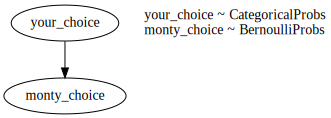

In [2]:
def monty_hall_1(your_choice=None, monty_choice=None):
    theta_you = numpyro.deterministic("theta_you", jnp.ones(3))
    your_choice = numpyro.sample(
        "your_choice",
        dist.Categorical(theta_you),
        infer={"enumerate": "parallel"},
        obs=your_choice,
    )

    theta_monty = numpyro.deterministic("theta_monty", jnp.asarray([1, 0, 0.5]))
    numpyro.sample(
        "monty_choice",
        dist.Bernoulli(Vindex(theta_monty)[your_choice]),
        infer={"enumerate": "parallel"},
        obs=monty_choice,
    )


monty_hall_1_predict = Predictive(
    monty_hall_1, num_samples=num_samples, infer_discrete=True
)

display(
    numpyro.render_model(monty_hall_1, render_distributions=True, render_params=False)
)


In [3]:
samples = monty_hall_1_predict(seed[0])

Counter(prizes[samples["your_choice"]])


Counter({'goat0': 343, 'goat1': 349, 'car': 308})

In [4]:
samples = monty_hall_1_predict(seed[1], your_choice=1)

print("Monty's choice: ", Counter(prizes[samples["monty_choice"]]))


Monty's choice:  Counter({'goat0': 1000})


In [5]:
samples = monty_hall_1_predict(seed[2], monty_choice=1)

print("Your choice: ", Counter(prizes[samples["your_choice"]]))


Your choice:  Counter({'goat0': 691, 'car': 309})


## Model 2


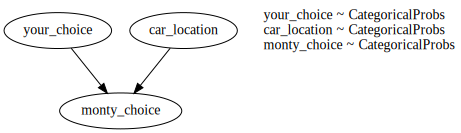

In [6]:
def monty_hall_2(your_choice=None, car_location=None, monty_choice=None):
    theta_you = numpyro.deterministic("theta_you", jnp.ones(3))
    your_choice = numpyro.sample(
        "your_choice",
        dist.Categorical(theta_you),
        infer={"enumerate": "parallel"},
        obs=your_choice,
    )

    theta_car = numpyro.deterministic("theta_car", jnp.ones(3))
    car_location = numpyro.sample(
        "car_location",
        dist.Categorical(theta_car),
        infer={"enumerate": "parallel"},
        obs=car_location,
    )

    theta_monty = numpyro.deterministic(
        "theta_monty",
        jnp.asarray(
            [
                [[0, 0.5, 0.5], [0, 0, 1], [0, 1, 0]],
                [[0, 0, 1], [0.5, 0, 0.5], [1, 0, 0]],
                [[0, 1, 0], [1, 0, 0], [0.5, 0.5, 0]],
            ]
        ),
    )
    numpyro.sample(
        "monty_choice",
        dist.Categorical(Vindex(theta_monty)[your_choice, car_location]),
        infer={"enumerate": "parallel"},
        obs=monty_choice,
    )


monty_hall_2_predict = Predictive(
    monty_hall_2, num_samples=num_samples, infer_discrete=True
)

display(
    numpyro.render_model(monty_hall_2, render_distributions=True, render_params=False)
)


In [7]:
samples = monty_hall_2_predict(seed[3])

Counter(doors[samples["car_location"]])


Counter({'door2': 309, 'door1': 324, 'door0': 367})

In [8]:
samples = monty_hall_2_predict(seed[4], monty_choice=1)

print("Car location: ", Counter(doors[samples["car_location"]]))
print("Your choice: ", Counter(doors[samples["your_choice"]]))


Car location:  Counter({'door2': 520, 'door0': 480})
Your choice:  Counter({'door2': 517, 'door0': 483})


In [9]:
samples = monty_hall_2_predict(seed[5], car_location=1)

print("Monty's choice: ", Counter(doors[samples["monty_choice"]]))
print("Your choice: ", Counter(doors[samples["your_choice"]]))


Monty's choice:  Counter({'door0': 500, 'door2': 500})
Your choice:  Counter({'door1': 354, 'door0': 328, 'door2': 318})


In [10]:
samples = monty_hall_2_predict(seed[6], your_choice=0, monty_choice=1)

Counter(doors[samples["car_location"]])


Counter({'door2': 677, 'door0': 323})